# Exploratory Data Analysis of (Mostly) Non-Text Data

## Resources:
- https://www.kaggle.com/artgor/toxicity-eda-logreg-and-nn-interpretation
- https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw
- https://www.kaggle.com/felipemello/there-is-no-medal-without-eda-comment-s-toxicity
- https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
- https://www.kaggle.com/tarunpaparaju/jigsaw-competition-part-of-speech-tagging
- https://www.kaggle.com/nholloway/how-word-embeddings-influence-bias 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import TweetTokenizer
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn import metrics
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
pd.set_option('max_colwidth',400)
pd.set_option('max_columns', 50)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
DATA_DIR = './../jigsaw-unintended-bias-in-toxicity-classification/'
TRAIN = 'train.csv'
TEST = 'test.csv'

In [3]:
train = pd.read_csv(os.path.join(DATA_DIR, TRAIN))

In [4]:
train.shape

(1804874, 45)

In [5]:
train.columns.values

array(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist',
       'bisexual', 'black', 'buddhist', 'christian', 'female',
       'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',
       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',
       'muslim', 'other_disability', 'other_gender',
       'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white',
       'created_date', 'publication_id', 'parent_id', 'article_id',
       'rating', 'funny', 'wow', 'sad', 'likes', 'disagree',
       'sexual_explicit', 'identity_annotator_count',
       'toxicity_annotator_count'], dtype=object)

In [6]:
print('Rate of unique comments:', train['comment_text'].nunique() / train['comment_text'].shape[0])

Rate of unique comments: 0.9866744160534198


In [7]:
def barPlot(data, x, y, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(9, 6))
    g = sns.barplot(x=x, y=y, data=data, color='red')
    g.set_xticklabels(labels=data[x], rotation=90)
    plt.tick_params(direction='inout', length=4, width=1, colors='black')
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.title(title, fontsize = 18)
    sns.despine(bottom=True)
    plt.show()

In [8]:
train['label'] = train['target'].apply(lambda x: x>= 0.5)
train.label.value_counts(normalize=True) 

False   0.9200
True    0.0800
Name: label, dtype: float64

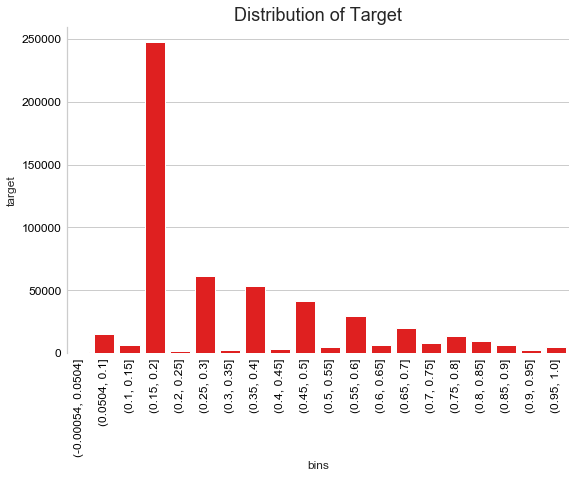

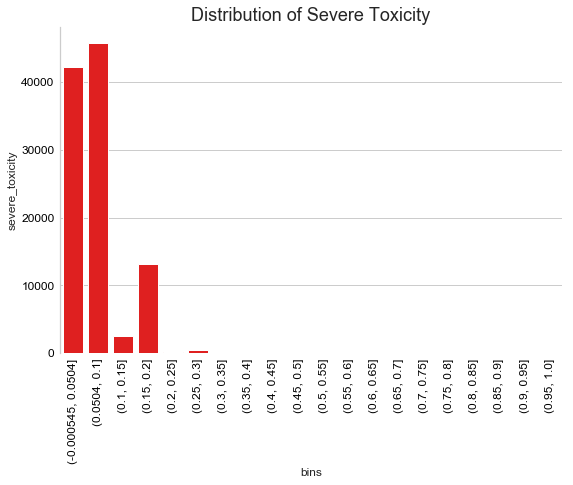

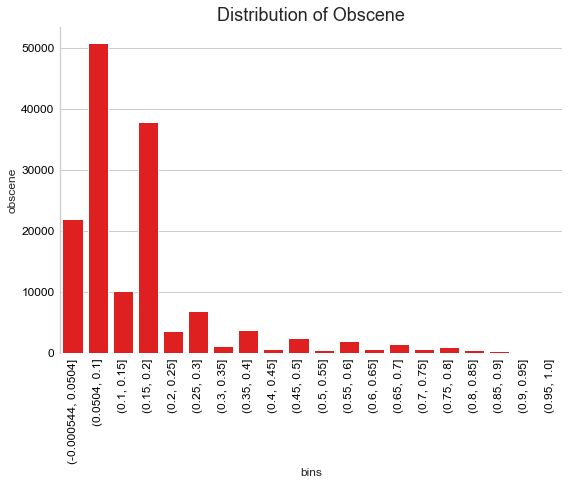

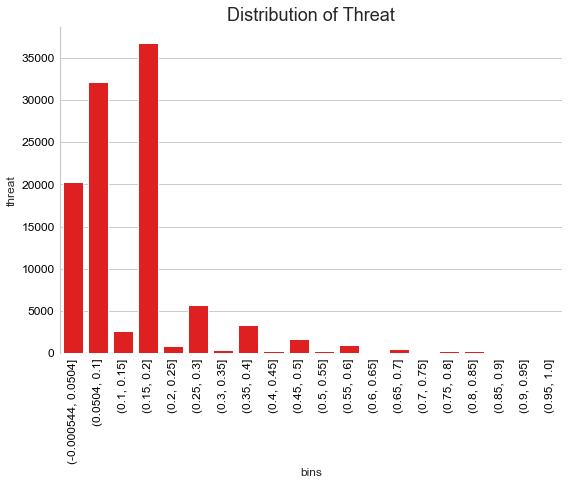

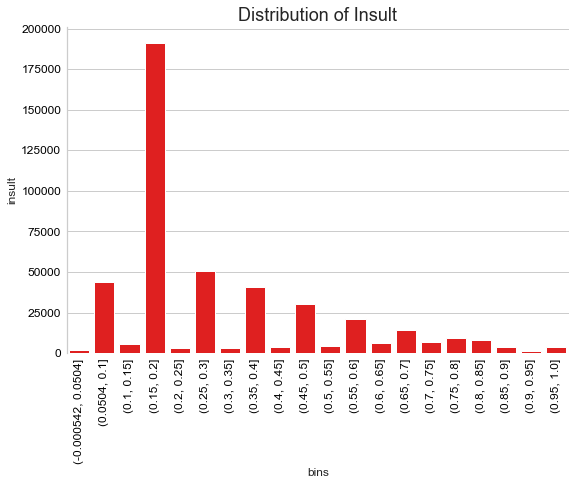

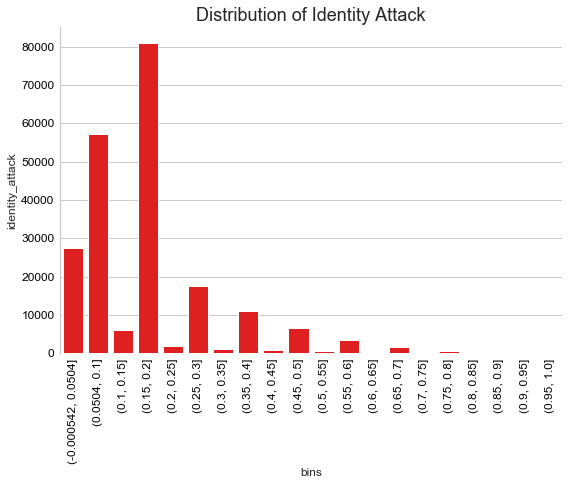

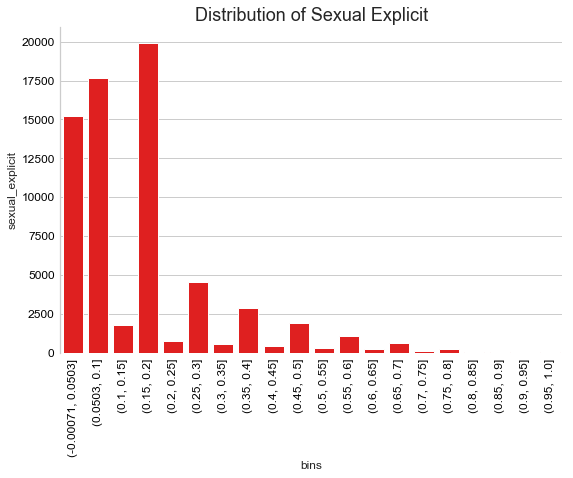

In [10]:
TOXICAT = ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
for col in ['target'] + TOXICAT:
    df_ = train.loc[train[col] > 0]
    hist_df = pd.cut(df_[col], 20).value_counts().sort_index().reset_index().rename(columns={'index': 'bins'})
    hist_df['bins'] = hist_df['bins'].astype(str)
    title = 'Distribution of {}'.format(' '.join(col.split('_')).title())
    barPlot(hist_df, 'bins', col, title)

In [11]:
# Some of the comments are labeled with identities, but only eight of them are included into evaluation: male, female, homosexual_gay_or_lesbian, christian, jewish, muslim, black, white, psychiatric_or_mental_illness.
identity_columns = ['asian', 'atheist',
       'bisexual', 'black', 'buddhist', 'christian', 'female',
       'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',
       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',
       'muslim', 'other_disability', 'other_gender',
       'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']
ID_EVAL = ['male', 'female', 'homosexual_gay_or_lesbian', 
             'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
REACS = ['funny', 'wow', 'sad', 'likes', 'disagree']
train[REACS].sum()

funny        501623
wow           79788
sad          196943
likes       4415024
disagree    1054712
dtype: int64

In [12]:
# BROADER IDENTITY GROUPS
religion_columns = ['atheist', 'buddhist', 'christian', 'hindu', 'jewish', 'muslim', 'other_religion']
gender_columns = ['male', 'female']
sexuality_columns = ['heterosexual', 'homosexual_gay_or_lesbian', 'other_gender', 'other_sexual_orientation', 'transgender']
ethinicity_columns = ['black', 'latino', 'white', 'asian', 'other_race_or_ethnicity']
mental_disability_columns = ['intellectual_or_learning_disability', 'psychiatric_or_mental_illness']

train['is_religion_related'] = (train[religion_columns] > 0).sum(axis=1)
train['is_gender_related'] = (train[gender_columns] > 0).sum(axis=1)
train['is_sexuality_related'] = (train[sexuality_columns] > 0).sum(axis=1)
train['is_ethnicity_related'] = (train[ethinicity_columns] > 0).sum(axis=1)
train['is_mental_disability_related'] = (train[mental_disability_columns] > 0).sum(axis=1)

# LIKES RATIO
pd.options.mode.chained_assignment = None  # desible copy warning - default='warn'
train['disagree_to_likes'] = 0
train['funny_to_likes'] = 0
train['wow_to_likes'] = 0
train['sad_to_likes'] = 0
train['all_reacs_to_likes'] = 0
train['disagree_to_likes'][train['likes'] > 0] = train['disagree'][train['likes'] > 0] / train['likes'][train['likes'] > 0]
train['funny_to_likes'][train['likes'] > 0] = train['funny'][train['likes'] > 0] / train['likes'][train['likes'] > 0]
train['wow_to_likes'][train['likes'] > 0] = train['wow'][train['likes'] > 0] / train['likes'][train['likes'] > 0]
train['sad_to_likes'][train['likes'] > 0] = train['sad'][train['likes'] > 0] /train['likes'][train['likes'] > 0]
train['all_reacs_to_likes'][train['likes'] > 0] = train[['disagree', 'funny', 'wow', 'sad']][train['likes'] > 0].sum(axis = 1) / train['likes'][train['likes'] > 0]

# COMMENTS PROPERTIES
train['rating'] = train['rating'].apply(lambda x: 1 if x =='approved' else 0)
train['has_parent_id'] = train['parent_id'].apply(lambda x: 1 if x > 0 else 0)
train['created_date'] = pd.to_datetime(train['created_date'])

# FILLING NaN
train.fillna(0, inplace=True)

In [13]:
reacc_cols = ['disagree_to_likes', 'funny_to_likes', 'wow_to_likes', 'sad_to_likes', 'all_reacs_to_likes']
reacc_target = train[reacc_cols + ['target']].corr()['target']
reacc_corr = reacc_target.drop('target').sort_values(ascending=False)
reacc_corr

disagree_to_likes     0.0153
all_reacs_to_likes    0.0101
sad_to_likes          0.0100
wow_to_likes          0.0069
funny_to_likes       -0.0070
Name: target, dtype: float64

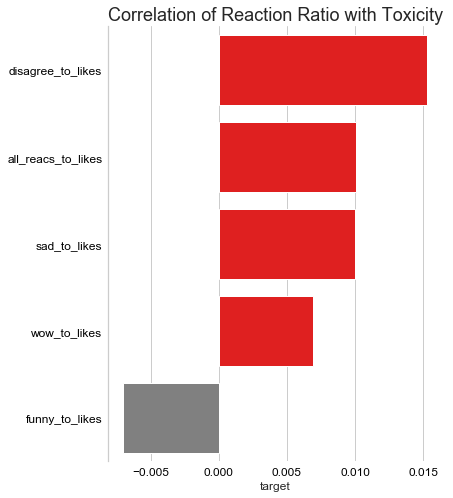

In [15]:
plt.figure(figsize=(6, 8))
colors = []
colors = ['red' if (x > 0) else 'gray' for x in reacc_corr.values]
g = sns.barplot(x=reacc_corr, y=reacc_corr.index, palette=colors)
plt.tick_params(direction='inout', length=4, width=1, colors='black')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Correlation of Reaction Ratio with Toxicity', fontsize = 18)
sns.despine(bottom=True)
plt.show()

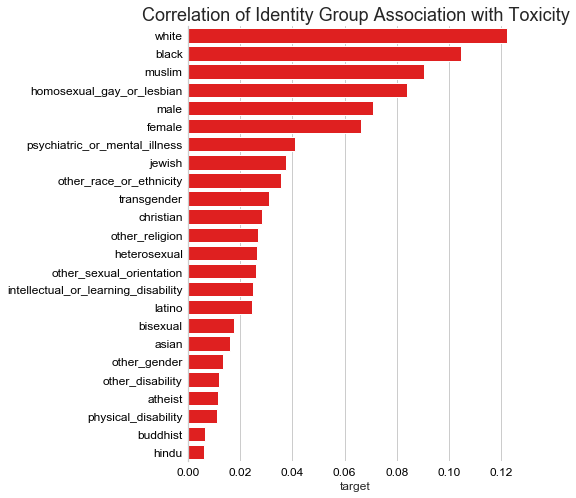

In [17]:
train_id_groups = train[identity_columns + ['target']]
id_corrs = train_id_groups.corr()['target'].drop('target').sort_values(ascending=False)
plt.figure(figsize=(6, 8))
g = sns.barplot(x=id_corrs, y=id_corrs.index, color='red')
plt.tick_params(direction='inout', length=4, width=1, colors='black')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Correlation of Identity Group Association with Toxicity', fontsize = 18)
sns.despine(bottom=True)
plt.show()

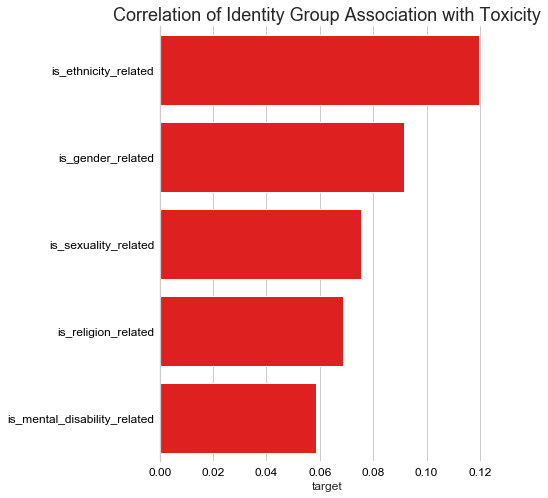

In [27]:
broad_id_groups = ['is_religion_related', 'is_gender_related', 'is_sexuality_related', 
                   'is_ethnicity_related', 'is_mental_disability_related'] 
train_bid = train[broad_id_groups + ['target']]
bid_corrs = train_bid.corr()['target'].drop('target').sort_values(ascending=False)
plt.figure(figsize=(6, 8))
g = sns.barplot(x=bid_corrs, y=bid_corrs.index, color='red')
plt.tick_params(direction='inout', length=4, width=1, colors='black')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Correlation of Identity Group Association with Toxicity', fontsize = 18)
sns.despine(bottom=True)
plt.show()

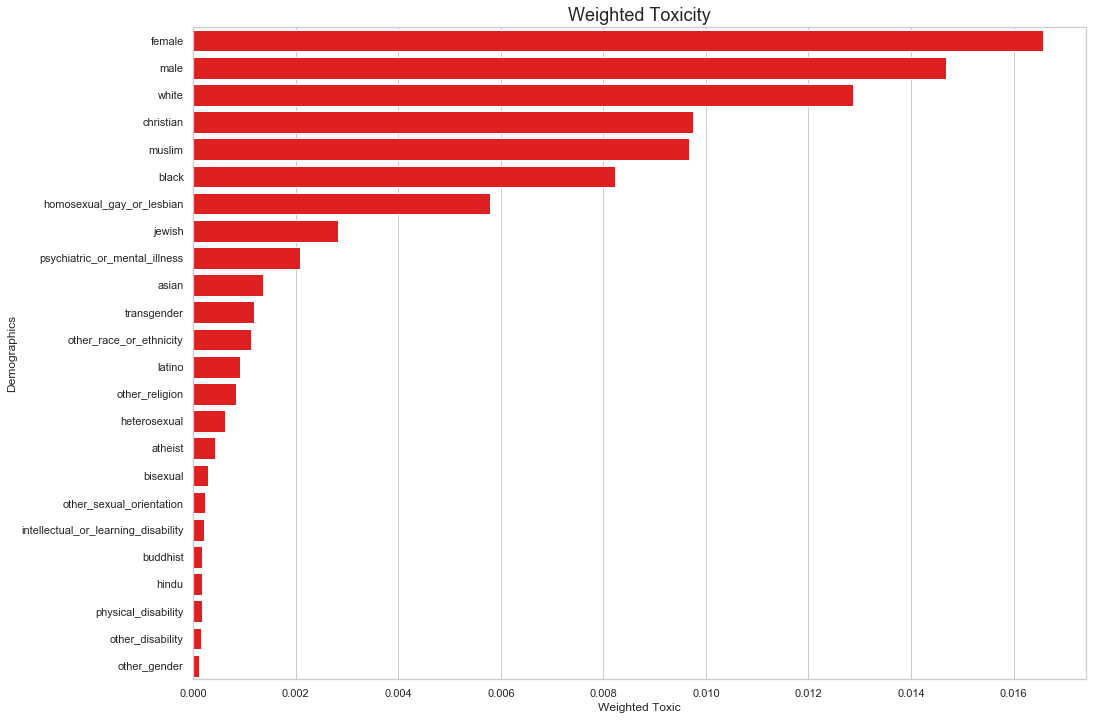

In [25]:
weighted_toxic = train_id_groups.iloc[:, :-1].multiply(train_id_groups.iloc[:, -1], axis="index").sum()/train_id_groups.iloc[:, :-1][train_id_groups.iloc[:, -1]>0].count()
weighted_toxic = weighted_toxic.sort_values(ascending=False)
plt.figure(figsize=(16, 12))
sns.set(style='whitegrid')
ax = sns.barplot(x = weighted_toxic.values, y = weighted_toxic.index, color='red')
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxic')
plt.title('Weighted Toxicity', fontsize=18)
plt.show()

### Hypothesis: Smart bullies reserve their toxic comments for the end. Toxicity occurs at end of text.

In [28]:
train['comment_text'].apply(lambda s: len(s)).describe()

count   1804874.0000
mean        297.2343
std         269.1966
min           1.0000
25%          94.0000
50%         202.0000
75%         414.0000
max        1906.0000
Name: comment_text, dtype: float64

In [29]:
def toxicwordcloud(subset, text_col, title, picture, cmap='Reds'):
    stopword=set(STOPWORDS)
    toxic_img = np.array(Image.open(picture))
    toxic_mask = toxic_img[:,:,1]
    text = ' '.join(subset[text_col].values)
    wc = WordCloud(background_color="black", max_words=4000, mask=toxic_mask, stopwords=stopword)
    wc.generate(text)
    
    # create coloring from image
    image_colors = ImageColorGenerator(toxic_img)

    plt.figure(figsize=(8,8))
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.imshow(wc.recolor(colormap=cmap), interpolation="bilinear")
    wc.to_file(title+'.png')


In [30]:
toxic_sub = train[train['label'] == 1]
tknzr = TweetTokenizer()

In [31]:
def last_k_words(s, last_k, tknzr):
    tkns = tknzr.tokenize(s)
    return ' '.join(tkns[-last_k:])

In [32]:
toxic_sub['last_five'] = toxic_sub['comment_text'].apply(last_k_words, args=(5, tknzr))

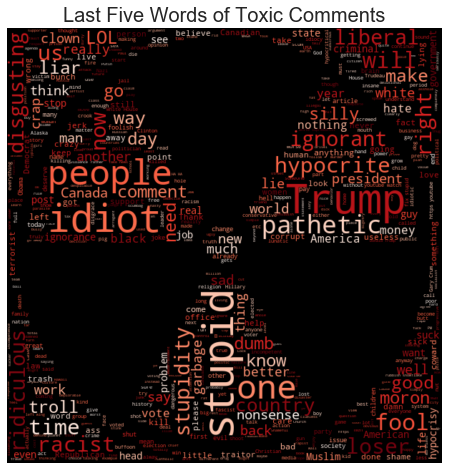

In [33]:
toxicwordcloud(toxic_sub, 'last_five', 'Last Five Words of Toxic Comments', 'toxic.png')

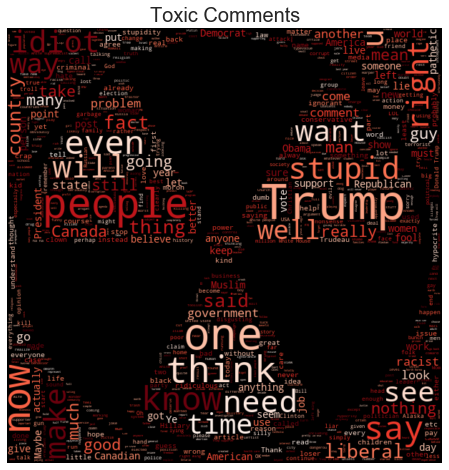

In [34]:
toxicwordcloud(toxic_sub, 'comment_text', 'Toxic Comments', 'toxic.png')